In [1]:
import numpy as np
import matplotlib.pyplot as plt
from style import set_style
from kinetics import *
from util import *


In [2]:
t_start = 0.0
t_end = 40.0

#Here, we define the time and energy range over which the spectrum is calculated.
energy = np.linspace(0.2, 4, 1000)
time = np.linspace(t_start, t_end, 1200)

#Next, we set the initial conditions and the cap on the populations.
initial_populations = np.array([
    1.0, 0.0, 0.0, 0.0
])

cap = np.array([
    1.0, 1.0, 1.0, 1.0
])

# These are convenience labels for the population indices.
G = 0
A = 1
C = 2
trap = 3

#Transition rates. These are arbitrary for now.

#Decay between states.
k_decay = 1.0
#Excitation between states.
k_exc = 1000.0
#Stimulated emission.
k_stim = 10.0
#Exciton to trap leve.
k_trap = 0.1
#Exciton-Exciton annihilation
k_an = 10.0

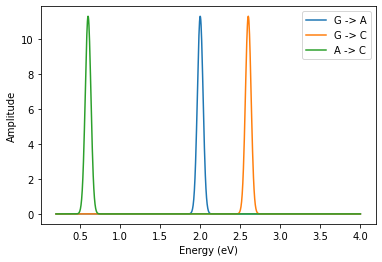

In [3]:
#Kernals describing what input radiation will be accepted to induce a transition.
#They are normalized so that they do not modify the strength of the excitation.
G_A_kernel = normalize(energy, gaussian(energy, center=2.0, sigma=0.05))
G_C_kernel = normalize(energy, gaussian(energy, center=2.6, sigma=0.05))
A_C_kernel = normalize(energy, gaussian(energy, center=0.6, sigma=0.05))

plt.figure()
for kernel, label in [(G_A_kernel, "G -> A"),
               (G_C_kernel, "G -> C"),
               (A_C_kernel, "A -> C")]:
    plt.plot(energy, kernel, label=label)

plt.xlabel("Energy (eV)")
plt.ylabel("Amplitude")
plt.legend()


In [4]:
#List of possible transitions
transitions = [
    Transition(kernel=G_A_kernel, rate=k_exc, start=G, end=A),
    Transition(kernel=G_C_kernel, rate=k_exc, start=G, end=C),
    Transition(kernel=A_C_kernel, rate=k_exc, start=A, end=C),
    Transition(kernel=None, rate=k_decay, start=A, end=G),
    Transition(kernel=None, rate=k_decay * 100.0, start=C, end=A),
    Transition(kernel=G_C_kernel * 2.0, rate=k_stim, start=C, end=A),
    Transition(kernel=G_A_kernel * 2.0, rate=k_stim, start=A, end=G),
    Transition(kernel=None, rate=k_trap, start=A, end=trap),
    Transition(kernel=None, rate=k_an, start=A, end=C, order=2.0)
]

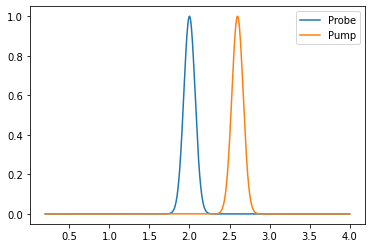

In [5]:
#Excitation spectra for the pump and probe pulses. The pump is aligned to the GS -> C exciton transition.
#The probe is aligned to the GS -> A exciton transition.
probe_spectrum = gaussian(energy, center=2.0, sigma=0.1)
pump_spectrum = gaussian(energy, center=2.6, sigma=0.1)

plt.figure()
plt.plot(energy, probe_spectrum, label="Probe")
plt.plot(energy, pump_spectrum, label="Pump")
plt.legend()

In [6]:

#The list of pump-probe time delays.
tau_list = np.linspace(2.0, 40.0, 20)

#The list of absorption spectra collected at each tau.
spectra = []

for tau in tau_list:
    #Here we define the pump and probe pulse time envelopes with lambda expressions.
    #This is a way in Python to define a function quickly.
    probe = lambda t: gaussian(t, tau, 0.01)
    pump = lambda t: gaussian(t, 2.0, 0.1)

    #This is the combined excitation defined in a similar way to above.
    exc_total = lambda t: pump(t) * pump_spectrum + probe(t) * probe_spectrum * 0.1

    #This defines the set of parameters for the simulation.
    params = Parameters(
        excitation=exc_total,
        transitions=transitions,
        initial_population=initial_populations,
        capacity=cap,
        energy=energy)

    #Finally we run a single simulation for a partiuclar tau value.
    results = run(params, time)

    #Sum through time to build the total absorbance over time.
    spectrum = np.sum(results.spectral_fluxes, axis=0)

    #Add to the list of spectra.
    spectra.append(spectrum)

#Convert to a matrix. Python does not support matrix types itself, so we use the numpy array.
spectra = np.array(spectra)

(0.0, 40.0)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


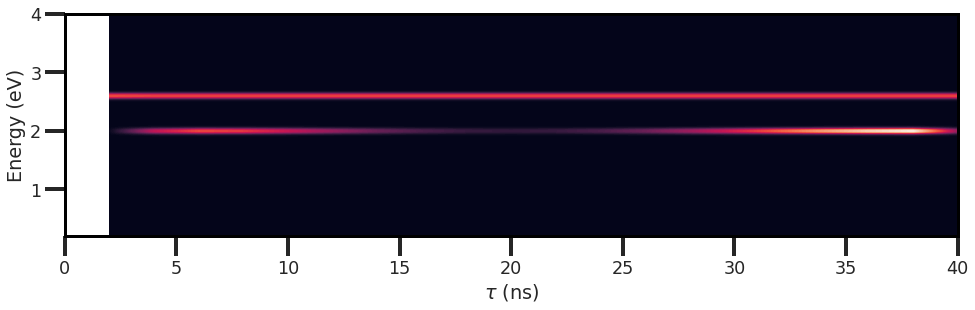

In [7]:

set_style()
plt.figure(figsize=(16, 9))

#Plot the TA spectrum.
plt.subplot(2, 1, 1)
plot_2d(tau_list, energy, np.transpose(spectra))
plt.xlabel("$\\tau$ (ns)")
plt.ylabel("Energy (eV)")
plt.xlim(0.0, np.max(time))

In [8]:
#Now we run a simple simulation with just the pump to get the population time dependence.
pump = lambda t: gaussian(t, 2.0, 0.1)

params = Parameters(lambda t: pump(t) * pump_spectrum, transitions, initial_populations, cap, energy)
result_simple = run(params, time)

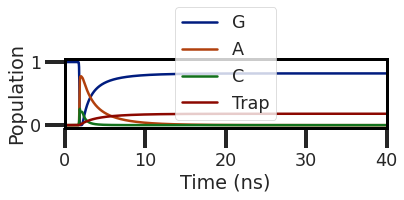

In [9]:
#Plot the populations.
plt.subplot(2, 1, 2)
plt.plot(result_simple.times, result_simple.populations[:, 0], label="G")
plt.plot(result_simple.times, result_simple.populations[:, 1], label="A")
plt.plot(result_simple.times, result_simple.populations[:, 2], label="C")
plt.plot(result_simple.times, result_simple.populations[:, 3], label="Trap")
plt.legend()
plt.ylabel("Population")
plt.xlabel("Time (ns)")
plt.xlim(0.0, np.max(time))


plt.tight_layout()
plt.savefig("TA.png", dpi=300)


plt.show()
